# Training for Behavioral Cloning

## Data Collection

Initially I collected several laps using the simulator.
For several days I tried training different models and I was not getting good results.
Since other students were getting good results with the provided sample dataset I decided to switch to that dataset to ensure that the issues that I was seeing were not related to the data I collected.

For the rest of this report I decided to use only the provided sample dataset.

Later on, when I got good results I switched back to my dataset and it turn out to be correct as well. I just need to find the right model.

## Exploratory Data Analysis

Let's review the images and metadata generated by the simulator.

#### Directory Structure

In [1]:
!tree | head -n 10

.
├── comma-ai-modified-v2.txt
├── comma-ai-modified-v4.txt
├── data
│   ├── driving_log.csv
│   └── IMG
│       ├── center_2016_12_01_13_30_48_287.jpg
│       ├── center_2016_12_01_13_30_48_404.jpg
│       ├── center_2016_12_01_13_31_12_937.jpg
│       ├── center_2016_12_01_13_31_13_037.jpg


The columns of `driving_log.csv` are:
    
    - Center Image
    - Left Image
    - Right Image
    - Steering Angle
    - Throttle
    - Break
    - Speed

#### Loading Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.style.use('ggplot')

In [3]:
col_names = ['center', 'left', 'right', 'angle',
             'throttle', 'break', 'speed']
df = pd.read_csv('data/driving_log.csv', names=col_names)
df.left = 'data/' + df.left.map(str.strip)
df.center = 'data/' + df.center.map(str.strip)
df.right = 'data/' + df.right.map(str.strip)

In [4]:
df.dtypes

center       object
left         object
right        object
angle       float64
throttle    float64
break       float64
speed       float64
dtype: object

#### Steering Angle

From the steering angle histogram below, we appreciate negative, positive and a large amount of near zero values. Negative values are from turning the wheel to the left side, positive to the right and zero when we are driving straight.

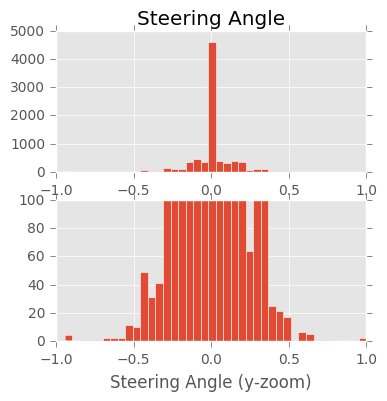

In [5]:
plt.figure(figsize=(4, 4))
plt.subplot(211)
df.angle.hist(bins=40)
plt.title('Steering Angle')
plt.subplot(212)
df.angle.hist(bins=40)
plt.xlabel('Steering Angle (y-zoom)')
plt.ylim((0, 100))
plt.show()

#### Images

Let's preview some of the images from the left, center and right cameras.

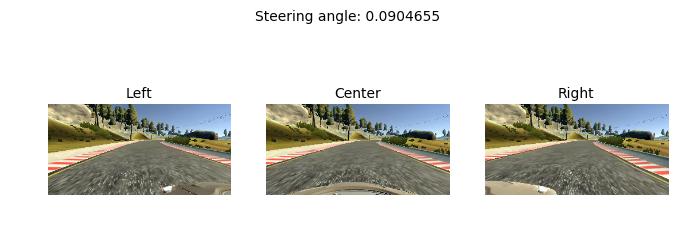

In [6]:
idx = 300
left_img = Image.open(df.left[idx])
center_img = Image.open(df.center[idx])
right_img = Image.open(df.right[idx])
angle_value = df.angle[idx]

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plt.title('Left', fontsize=10)
plt.grid('off')
plt.axis('off')
plt.imshow(left_img)
plt.subplot(1, 3, 2)
plt.title('Center', fontsize=10)
plt.grid('off')
plt.axis('off')
plt.imshow(center_img)
plt.subplot(1, 3, 3)
plt.title('Right', fontsize=10)
plt.grid('off')
plt.axis('off')
plt.imshow(right_img)
plt.suptitle('Steering angle: %s' % angle_value, fontsize=10)
plt.show()

Each of the images offers a different perspective. We use the steering angle as output of the center image. 

## Data Preprocessing

Let's generate our testing, training and validation sets. At this point, only the file paths and steering values are manipulated. The images will be loaded in memory during the training phase.

In [7]:
import cv2
import json
from sklearn.model_selection import train_test_split

After several experiments using the steering angle including all the data where the steering angle is zero, the model never performed well.
The same issue is described in the paper [End-to-End Deep Learning for Self-Driving Cars](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) and [blog](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/). 

In their paper they reduce the data for which the steering angle is from driving straight.

In this project after a few trials, I decided to remove completely the data with exactly zero steering angle.
That make the model drive the car more smoothly.


In [8]:
data = df[(df.angle != 0)]

Now the steering angle data has an almost gaussian distribution.

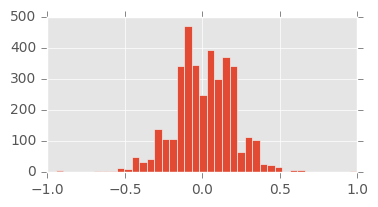

In [9]:
plt.figure(figsize=(4, 2))
data.angle.hist(bins=40)
plt.show()

#### Generate the training, validation and testing datasets

In [10]:
partial_data, test_data = train_test_split(data,
                                           test_size=0.05,
                                           random_state=0)

train_data, valid_data = train_test_split(partial_data,
                                          test_size=0.1,
                                          random_state=0)

In [11]:
print("Columns: %s" % train_data.columns.values)
print("train shape: %s" % (train_data.shape,))
print("valid shape: %s" % (valid_data.shape,))
print("test shape: %s" % (test_data.shape,))

Columns: ['center' 'left' 'right' 'angle' 'throttle' 'break' 'speed']
train shape: (3141, 7)
valid shape: (350, 7)
test shape: (184, 7)


## Design Model Architecture

For the initial design, I decided to start with the model from [comma.ai](http://comma.ai/) found in their GitHub repo [research](https://github.com/commaai/research) in the file [train_steering_model.py](https://github.com/commaai/research/blob/master/train_steering_model.py#L24-L46)

The original **comma.ai** model has the following layers:

    Input Image (160x320x3)
    Normalization (Lambda layer with MinMax between -1.0 and 1.0)
    Convolution (16, 8, 8)
    ELU
    Convolution (32, 5, 5)
    ELU
    Convolution (64, 5, 5)
    Flatten
    Dropout (0.2)
    ELU
    Dense (512)
    Dropout (0.5)
    ELU
    Dense (1)
    
Inititally I tried that model, but in none of my trials the model was able to drive the car the whole track. The car will drive a few turns and then leave the track.

After adding additional convolution layers to give the model more complexity, it was able to drive the car the whole track:

    Input Image (160x320x3)
    Normalization (Lambda layer with MinMax between -1.0 and 1.0)
    Convolution (16, 8, 8)
    Convolution (16, 8, 8)
    Convolution (16, 8, 8)
    ELU
    Convolution (32, 5, 5)
    Convolution (32, 5, 5)
    Convolution (32, 5, 5)
    ELU
    Convolution (64, 5, 5)
    Convolution (64, 5, 5)
    Convolution (64, 5, 5)
    Flatten
    Dropout (0.5)
    ELU
    Dense (512)
    Dense (64)
    Dense (8)
    Dropout (0.5)
    ELU
    Dense (1)

The model generated a weights file of **1.7MB** and the car was able to complete **Track #1** without problems after a training with about **120K** images (5 epochs of 20K images). This model was never able to drive more than a couple turns in **Track #2** though. This model was *memorizing* the frames from **Track #1** and not generalizing enough for **Track #2**.

I tried several other models, and then found one reducing the size of the images and model complexity that can better handle **Track #2**:

    Input Image (64x128x3)
    Normalization (Lambda layer with MinMax between -1.0 and 1.0)
    Convolution (16, 8, 8)
    Convolution (16, 8, 8)
    ELU
    Convolution (32, 5, 5)
    Convolution (32, 5, 5)
    ELU
    Convolution (64, 5, 5)
    Convolution (64, 5, 5)
    Flatten
    Dropout (0.5)
    ELU
    Dense (64)
    Dense (64)
    Dense (8)
    Dropout (0.5)
    ELU
    Dense (1)

This last model generates a weights file of only **1.1MB** and can drive the car smoothly on **Track #1** and almost as good **Track #2**.

All the models I tried use an **Adam** optimizer and **MSE** for loss.

For regularization it has two dropout layers.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.callbacks import Callback

Using TensorFlow backend.


In [13]:
def min_max_norm(x):
    a = -1.
    b = 1.
    
    return a + x * (b - a)/(255.0 - 0.0)

In [14]:
def build_model():
    rows, cols, channels = 64, 128, 3
    shape = (rows, cols, channels)
    
    model = Sequential()
    model.add(Lambda(min_max_norm, input_shape=shape, output_shape=shape))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode='same'))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(ELU())
    model.add(Flatten())
    model.add(Dropout(.5))
    model.add(Dense(512))
    model.add(Dense(64))
    model.add(Dense(8))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    return model

## Training

As recommended by this project instructions, let's implement the network training using the [fit_generator](https://keras.io/models/model/#fit_generator) method from Keras to avoid loading all the images in memory.

#### Data Augmentation

In addition to the original camera images, let's generate synthetic images from the original images using transformations. The transformations were based on the source code from these sources:

- [Keras' ImageDataGenerator](https://keras.io/preprocessing/image/)
- [Kaggle's Plankton Competition Winner](http://benanne.github.io/2015/03/17/plankton.html)
- [Image Augmentation with Keras](http://machinelearningmastery.com/image-augmentation-deep-learning-keras/)
- [Vivek Yadav's An augmentation based deep neural network approach to learn human driving behavior](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.egwkyuy0t)

In particular the functions for shadow, brightness and translation augmentation were taken from Vivek's example.

The following image augmentation methods were used:

- brightness (transforms image)
- shadow (transforms image)
- flip (transforms image and angle)    
- translation (transforms image and angle)
- rotation (transforms image and angle)

Another important feature that improved dramatically the performance of the model was cropping.

I removed the top 80 pixel rows and the bottom 20 pixel rows. This to remove the scenary (sky, trees, mountains on the top of the image and the car hood on the bottom of the image) and allow the model to focus more on the road itself.

That reduced the size of the image from **160x320** pixels to **60x320** pixels.

In [15]:
def load_image(path):
    # Load the image
    image = cv2.imread(path)
    
    # drive.py sends the image as RGB (OpenCV reads as BGR)
    # https://carnd-forums.udacity.com/questions/26214464/answers/26215455
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

In [16]:
def load_from_camera(row):
    # Random camera
    cam = np.random.randint(3)
    
    if (cam == 0):
        path = row.left
        delta = 0.25
    elif (cam == 1):
        path = row.center
        delta = 0.0
    else:
        path = row.right
        delta = -0.25

    # Adjust the steering angle
    angle = row.angle + delta
    
    # Load image in RGB format
    image = load_image(path)
    
    return (image, angle)

In [17]:
def augment_flip(image, angle):
    flip = np.random.randint(2)
    if (flip == 0):
        image = cv2.flip(image, 1)
        angle = -angle
        
    return (image, angle)

In [18]:
def augment_rotation(image, angle):
    rows, cols, channels = image.shape
    rot = np.random.uniform(-5, 5)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), rot, 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    angle = angle + 0.05 * rot
    
    return (image, angle)

In [19]:
def augment_translation(image, angle):
    tr_x = np.random.uniform(-10, 10)
    angle = angle + tr_x / 20 * 2 * 0.2
    tr_y = np.random.uniform(-10, 10)
    M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image = cv2.warpAffine(image, M, (320, 160))
    
    return (image, angle)

In [20]:
def augment_brightness(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    bright = 0.25 + np.random.uniform()
    image[:, :, 2] = image[:, :, 2] * bright
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    
    return image

In [21]:
def augment_shadow(image):
    top_y = 320 * np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320 * np.random.uniform()
    image_hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    shadow_mask = 0 * image_hls[:, :, 1]
    X_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0], 0:image.shape[1]][1]
    shadow_mask[((X_m - top_x)*(bot_y - top_y)-(bot_x - top_x)*(Y_m - top_y) >= 0)] = 1

    if np.random.randint(2) == 1:
        random_bright = 0.5
        cond1 = shadow_mask == 1
        cond0 = shadow_mask == 0
        if np.random.randint(2) == 1:
            image_hls[:, :, 1][cond1] = image_hls[:, :, 1][cond1] * random_bright
        else:
            image_hls[:, :, 1][cond0] = image_hls[:, :, 1][cond0] * random_bright
            
    image = cv2.cvtColor(image_hls, cv2.COLOR_HLS2RGB)
    
    return image

In [22]:
def crop_and_resize(image):
    image = image[80:140, :, :]
    image = cv2.resize(image, (128, 64))
    
    return image

In [23]:
image = load_image(data.center.values[0])

In [24]:
image.shape

(160, 320, 3)

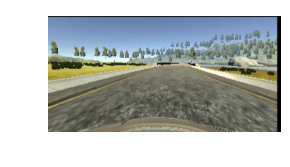

In [25]:
plt.figure(figsize=(3, 2))
plt.imshow(augment_translation(image, data.angle.values[0])[0])
plt.axis('off')
plt.show()

In [26]:
crop_and_resize(image).shape

(64, 128, 3)

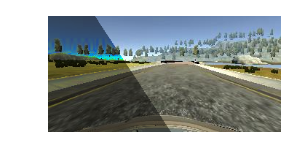

In [27]:
plt.figure(figsize=(3, 2))
plt.imshow(augment_shadow(image))
plt.axis('off')
plt.show()

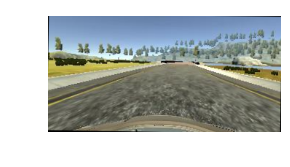

In [28]:
plt.figure(figsize=(3, 2))
plt.imshow(augment_rotation(image, 0)[0])
plt.axis('off')
plt.show()

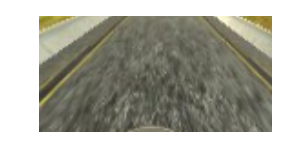

In [29]:
plt.figure(figsize=(3, 2))
plt.imshow(crop_and_resize(image))
plt.axis('off')
plt.show()

In [30]:
def generate_augmented_image_and_angle(row):
    image, angle = load_from_camera(row)
    image = augment_brightness(image)
    image = augment_shadow(image)
    image, angle = augment_flip(image, angle)    
    image, angle = augment_translation(image, angle)
    image, angle = augment_rotation(image, angle)
    image = crop_and_resize(image)
    
    return (image, angle)

In [31]:
def generate_image_and_angle(row):
    image, angle = load_from_camera(row)
    image = crop_and_resize(image)
    
    return (image, angle)

In [32]:
def plot_images(images):
    fig, axes = plt.subplots(15, 6, figsize=(8, 10))
    subplots = axes.ravel()
    
    for n, subplot in enumerate(subplots):
        image = images[n]
        subplots[n].imshow(image)
        subplots[n].axis('off')
    plt.show()

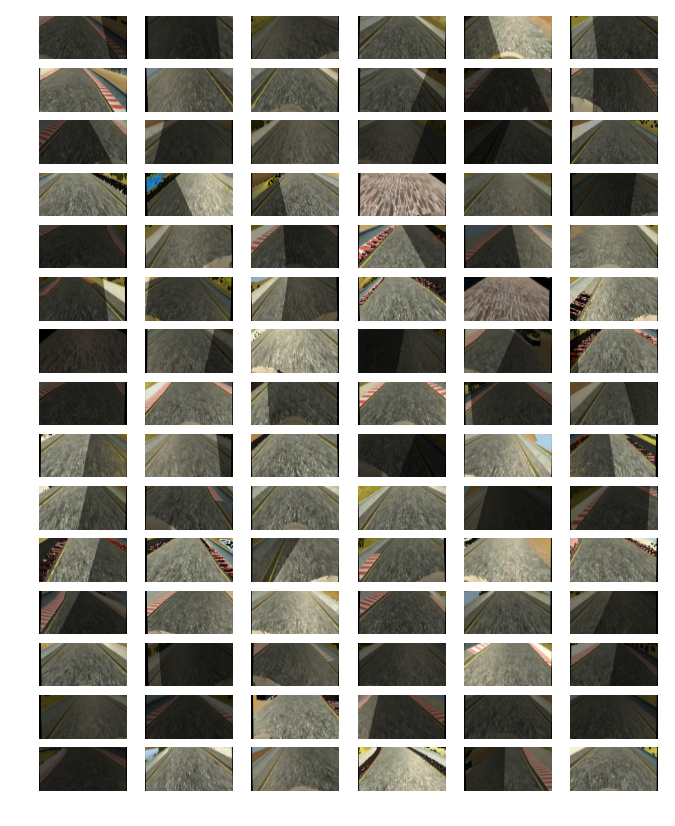

In [33]:
demo_images = []
for idx, row in train_data.sample(90).iterrows():
    img, ang = generate_augmented_image_and_angle(row)
    demo_images.append(img)
plot_images(demo_images)

### Data Generators

There are two data generators, one that is used for training that does the aumentation on-the-fly and the other one for the validation which does only the image cropping.

In [34]:
def generate_augmented_data(data, batch_size):
    
    while 1:
        images = []
        angles = []
        
        samples = data.sample(batch_size)

        for idx, row in samples.iterrows():
            img, ang = generate_augmented_image_and_angle(row)
            images.append(img)
            angles.append(ang)
        
        yield (np.array(images), np.array(angles))

In [35]:
def generate_data(data, batch_size):
    
    while 1:
        images = []
        angles = []
        
        samples = data.sample(batch_size)

        for idx, row in samples.iterrows():
            img, ang = generate_image_and_angle(row)
            images.append(img)
            angles.append(ang)
        
        yield (np.array(images), np.array(angles))


In [36]:
model = build_model()

#### Logging Callback

We use a callback to save the values of the training to generate a loss plot.

In [37]:
class ModelLogger(Callback):
    
    def __init__(self):
        self.batch_loss = []
        self.batch = []
        self.loss = []
        self.val_loss = []
        self.batch = []
        
    def on_batch_end(self, epoch, logs={}):
        self.batch_loss.append(logs['loss'])
        self.batch.append(logs['batch'])
    
    def on_epoch_end(self, epoch, logs={}):
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        

In [38]:
batch_losses = []
losses = []
val_losses = []

for i in range(30):
    logger = ModelLogger()
    
    model.fit_generator(
        generate_augmented_data(train_data, batch_size=256),
        samples_per_epoch=20480,
        nb_epoch=1,
        validation_data=generate_data(valid_data, batch_size=256),
        nb_val_samples=512,
        callbacks=[logger]
    )

    model_json = model.to_json()
    with open('model.v6.%d.json' % i, 'w') as f:
        json.dump(model_json, f)

    model.save_weights('model.v6.%d.h5' % i)
    
    batch_losses += logger.batch_loss
    losses += logger.loss
    val_losses += logger.val_loss

Epoch 1/1
20480/20480 [==============================] - 86s - loss: 0.0813 - val_loss: 0.0394

### Ploting Training and Validation Loss

The following graph show losses per batch and per epoch from the model training.
Each epoch contains 20480 images trained in batches of 256 images.

After the 5th epoch, the model generated is able to drive the car completely in **Track #1** and after the 6th epoch in **Track #2**.

The model is not able to complete **Track #2** when the maximum quality setting is enabled in the simulator. Shadows confuse the model after a few turns.

In **Simple** quality mode the car completes **Track #2** even with shadows on the road.

This table show the success of the model in completing the track:

    |-----------|----------|----------|
    |  Quality  | Track #1 | Track #2 |
    |===========|==========|==========|
    | Fastest   | Yes      | Yes      |
    | Fast      | Yes      | Yes      |
    | Simple    | Yes      | Yes      |
    | Good      | Yes      | No       |
    | Beautiful | Yes      | No       |
    | Fantastic | Yes      | No       |
    |-----------|----------|----------|

For quality up to *Simple*, the model is able to drive both tracks successfully:

    |-------------|----------|----------|
    |  Resolution | Track #1 | Track #2 |
    |=============|==========|==========|
    | 640 x 480   | Yes      | Yes      |
    | 800 x 600   | Yes      | Yes      |
    | 960 x 720   | Yes      | Yes      |
    | 1024 x 768  | Yes      | Yes      |
    | 1152 x 864  | Yes      | Yes      |
    | 1280 x 960  | Yes      | Yes      |
    | 1400 x 1050 | Yes      | Yes      |
    |-------------|----------|----------|

Here are some videos of the model in action:

- [Track #1 - Simple 640x480](https://youtu.be/9i_zpgNhWvs)
- [Track #2 - Simple 640x480](https://youtu.be/oHsuGogx8co)
- [Track #2 - Simple 1280x960](https://youtu.be/rZ3SMVFfNZg)


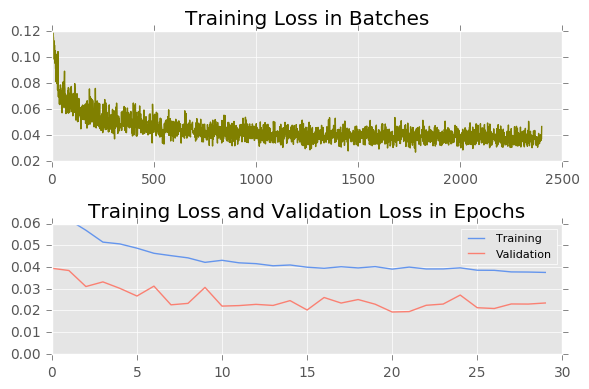

In [39]:
batches_plot = plt.subplot(211)
batches_plot.set_title('Training Loss in Batches')
batches_plot.plot(batch_losses, 'olive')

epochs_plot = plt.subplot(212)
epochs_plot.set_title('Training Loss and Validation Loss in Epochs')
epochs_plot.plot(losses, 'cornflowerblue', label='Training')
epochs_plot.plot(val_losses, 'salmon', label='Validation')
epochs_plot.set_ylim([0, 0.06])
epochs_plot.legend(loc=1, prop={'size': 8})
plt.tight_layout()
plt.show()

Any model above epoch 8 (training with 160k images or more) was able to drive the car successfully.

---

### Model Evaluation

#### Testing samples

Now let's get some samples with negative, positive and zero steering angles from the testing dataset.

Using the testing dataset, we plot how close the predictions are to the testing values.
From the histogram of values we can see that the predictions do not generate similar distributions, their extremes spill over in both sides, towards the positive and negative sides.

This would make us conclude that the performance is not good, but when testing the model, the car drives as expected.

This result is counterintuitive, I expected to find similar distribution for the real and predicted values.

In [40]:
pos_angles = test_data[test_data.angle > 0.1]
neg_angles = test_data[test_data.angle < -0.1]
zero_angles = test_data[(test_data.angle > -0.1) & (test_data.angle < 0.1)]

In [41]:
print('Positive steering angle samples: %s' % (pos_angles.shape,))
print('Negative steering angle samples: %s' % (neg_angles.shape,))
print('Near zero steering angle samples: %s' % (zero_angles.shape,))


Positive steering angle samples: (60, 7)
Negative steering angle samples: (48, 7)
Near zero steering angle samples: (76, 7)


In [42]:
pred_pos = model.predict_generator(
    generate_data(pos_angles, batch_size=40),
    val_samples=40
)

In [43]:
pred_neg = model.predict_generator(
    generate_data(neg_angles, batch_size=40),
    val_samples=40
)

In [44]:
pred_zero = model.predict_generator(
    generate_data(zero_angles, batch_size=40),
    val_samples=40
)

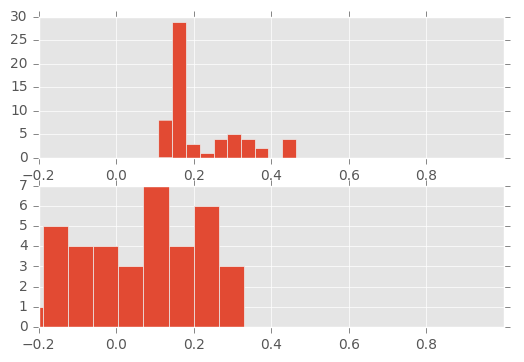

In [45]:
plt.subplot(211)
plt.hist(pos_angles.angle.values)
plt.xlim((-.2, 1.))
plt.subplot(212)
plt.hist(pred_pos)
plt.xlim((-.2, 1.))
plt.show()

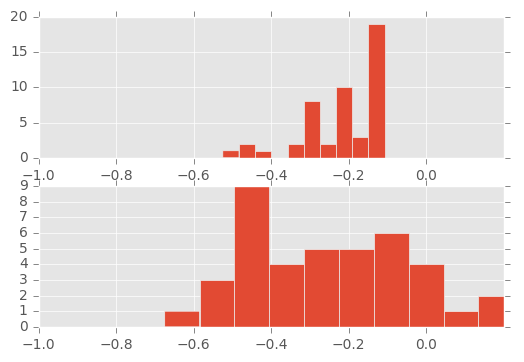

In [46]:
plt.subplot(211)
plt.hist(neg_angles.angle.values)
plt.xlim((-1., .2))
plt.subplot(212)
plt.hist(pred_neg)
plt.xlim((-1., .2))
plt.show()

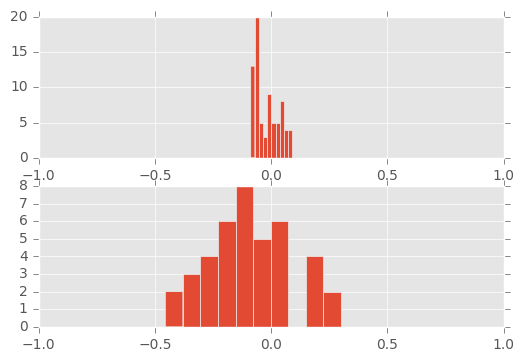

In [47]:
plt.subplot(211)
plt.hist(zero_angles.angle.values)
plt.xlim((-1., 1.))
plt.subplot(212)
plt.hist(pred_zero)
plt.xlim((-1., 1.))
plt.show()